In [1]:
import ROOT
import os
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from pathlib import Path

plt.rcParams.update({'font.size': 12})

cling::DynamicLibraryManager::loadLibrary(): libGLU.so.1: cannot open shared object file: No such file or directory
Error in <AutoloadLibraryMU>: Failed to load library /home/iwsatlas1/bhuth/thirdparty/ROOT/lib/libEve.so.6.28.02cling JIT session error: Failed to materialize symbols: { (main, { _ZeqRK7TStringRKNSt7__cxx1112basic_stringIcSt11char_traitsIcESaIcEEE }) }


Welcome to JupyROOT 6.28/02


In [2]:
def plotTEfficency(tefficency, ax, **errorbar_kwargs):
    th1 = tefficency.GetTotalHistogram()
    
    bins = [ i for i in range(th1.GetNbinsX()) if th1.GetBinContent(i) > 0.0 ]
    
    x = [ th1.GetBinCenter(i) for i in bins ]

    x_lo = [ th1.GetBinLowEdge(i) for i in bins ]
    x_width = [ th1.GetBinWidth(i) for i in bins ]
    x_hi = np.add(x_lo, x_width)
    x_err_lo = np.subtract(x, x_lo)
    x_err_hi = np.subtract(x_hi, x)

    y = [ tefficency.GetEfficiency(i) for i in bins ]
    y_err_lo = [ tefficency.GetEfficiencyErrorLow(i) for i in bins ]
    y_err_hi = [ tefficency.GetEfficiencyErrorUp(i) for i in bins ]

    ax.errorbar(x, y, yerr=(y_err_lo, y_err_hi), xerr=(x_err_lo, x_err_hi), **errorbar_kwargs)
    return ax

In [3]:
def show_performance_in_df(performance, label="value", df=None):
    if df is None:
        keys = ["eff_tracks", "fakerate_tracks", "duplicaterate_tracks", "eff_particles", "fakerate_particles", "duplicaterate_particles"]
        df = pd.DataFrame({"key": keys})
    else:
        keys = df["key"]
        
    df[label] = [ performance.Get(key)[0] for key in keys ]
    return df
    #print(df.to_string(formatters={"value": "{:.2%}".format}))

In [4]:
def open_with_time(path):
    print("open '{}' (modified {}".format(path, time.ctime(os.path.getmtime(path))))
    return ROOT.TFile.Open(str(path))

In [5]:
path = Path("../output_gnn_ckf_no_threshold")

In [14]:
performance_ckf = open_with_time(path / "performance_standard_ckf.root")
performance_gnn_ckf = open_with_time(path / "performance_gnn_plus_ckf.root")
performance_proof_of_concept = open_with_time(path / "performance_proof_of_concept.root")
performance_truth_kalman = open_with_time(path / "performance_truth_kalman.root")

open '../output_gnn_ckf_no_threshold/performance_standard_ckf.root' (modified Tue Aug 29 17:37:48 2023
open '../output_gnn_ckf_no_threshold/performance_gnn_plus_ckf.root' (modified Tue Aug 29 17:37:48 2023
open '../output_gnn_ckf_no_threshold/performance_proof_of_concept.root' (modified Tue Aug 29 17:34:51 2023
open '../output_gnn_ckf_no_threshold/performance_truth_kalman.root' (modified Tue Aug 29 17:37:48 2023


In [15]:
for k in performance_ckf.GetListOfKeys():
    k.Print()

TKey Name = trackeff_vs_pT, Title = Tracking efficiency, Cycle = 1
TKey Name = trackeff_vs_eta, Title = Tracking efficiency, Cycle = 1
TKey Name = trackeff_vs_phi, Title = Tracking efficiency, Cycle = 1
TKey Name = nRecoTracks_vs_pT, Title = Number of reconstructed track candidates, Cycle = 1
TKey Name = nTruthMatchedTracks_vs_pT, Title = Number of truth-matched track candidates, Cycle = 1
TKey Name = nFakeTracks_vs_pT, Title = Number of fake track candidates, Cycle = 1
TKey Name = nRecoTracks_vs_eta, Title = Number of reconstructed track candidates, Cycle = 1
TKey Name = nTruthMatchedTracks_vs_eta, Title = Number of truth-matched track candidates, Cycle = 1
TKey Name = nFakeTracks_vs_eta, Title = Number of fake track candidates, Cycle = 1
TKey Name = fakerate_vs_pT, Title = Tracking fake rate, Cycle = 1
TKey Name = fakerate_vs_eta, Title = Tracking fake rate, Cycle = 1
TKey Name = fakerate_vs_phi, Title = Tracking fake rate, Cycle = 1
TKey Name = duplicationRate_vs_pT, Title = Duplica

In [16]:
df = show_performance_in_df(performance_ckf, "CKF only")
df = show_performance_in_df(performance_gnn_ckf, "GNN+CKF", df)
df = show_performance_in_df(performance_proof_of_concept, "proof of concept", df)
df

,key,CKF only,GNN+CKF,proof of concept
0,eff_tracks,0.215526,0.744571,0.994124
1,fakerate_tracks,0.126134,0.010146,0.004407
2,duplicaterate_tracks,0.191008,0.433784,0.422455
3,eff_particles,0.578985,0.848775,0.966986
4,fakerate_particles,0.421015,0.016684,0.004615
5,duplicaterate_particles,0.425275,0.287540,0.339723


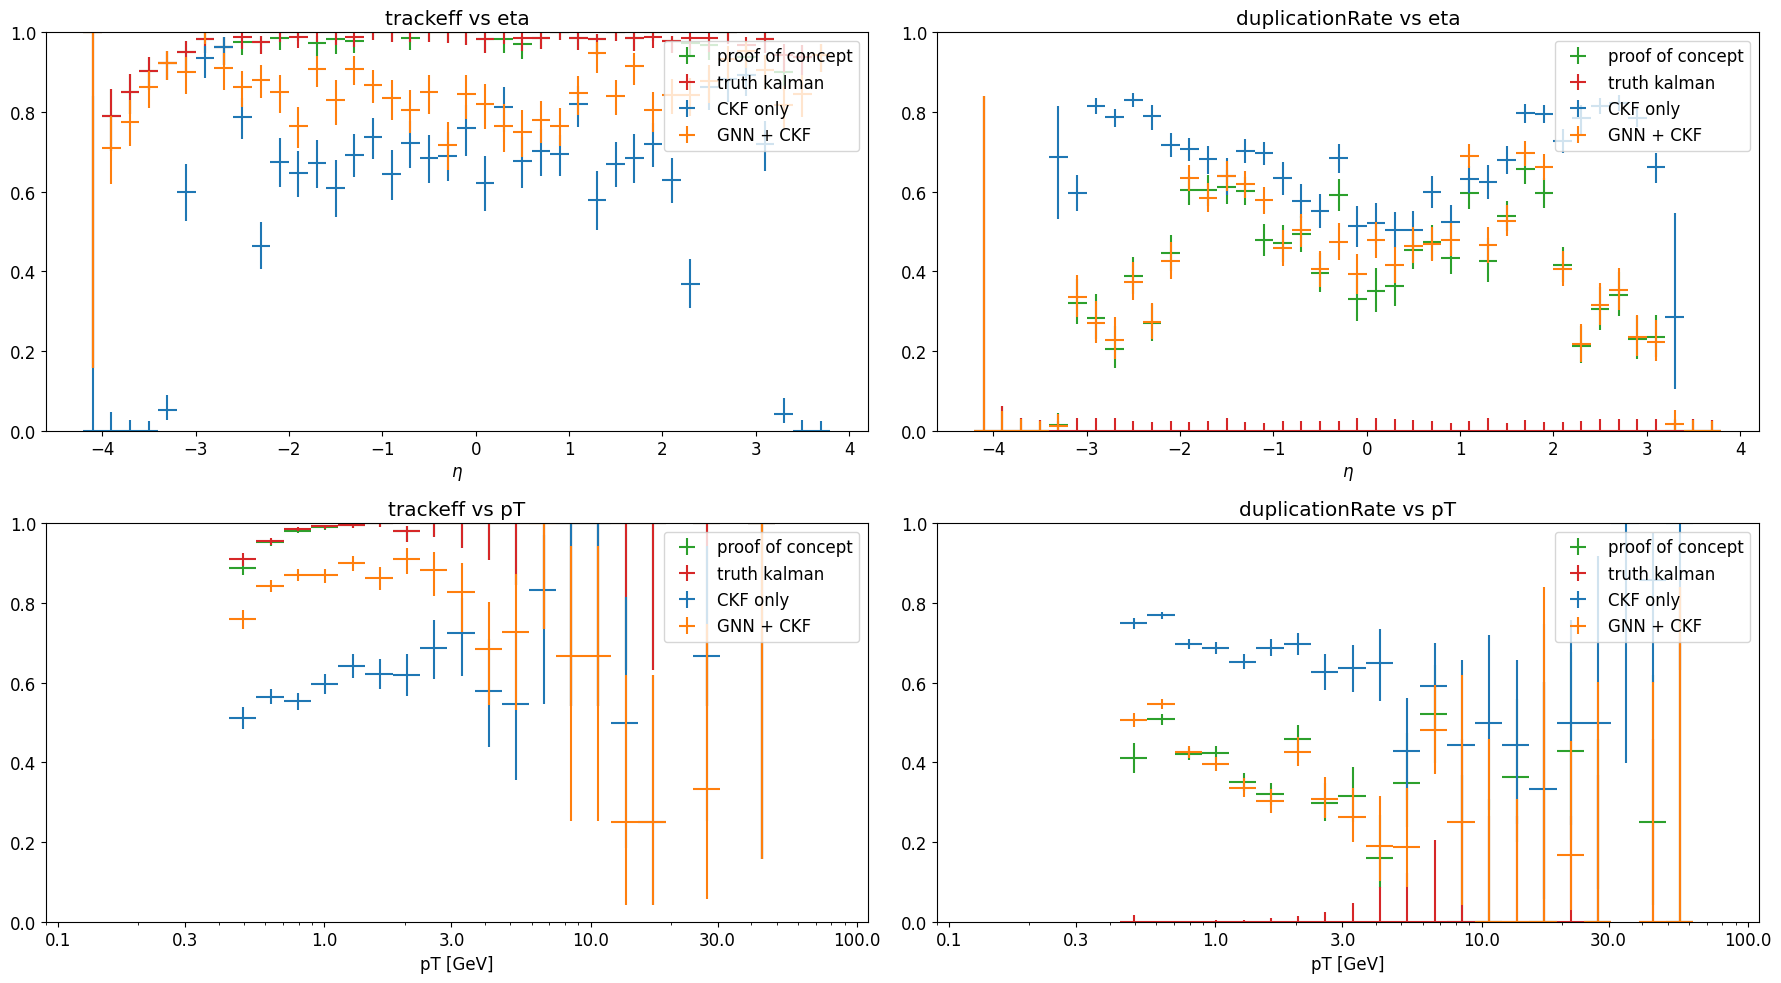

In [18]:
fig, axes = plt.subplots(2,2,figsize=(18,10))

for ax, key in zip(axes.flatten(), ['trackeff_vs_eta', 'duplicationRate_vs_eta', 'trackeff_vs_pT', 'duplicationRate_vs_pT']):
    plotTEfficency(performance_proof_of_concept.Get(key), ax, fmt="none", color="tab:green", label="proof of concept")
    plotTEfficency(performance_truth_kalman.Get(key), ax, fmt="none", color="tab:red", label="truth kalman")
    plotTEfficency(performance_ckf.Get(key), ax, fmt="none", color="tab:blue", label="CKF only")
    plotTEfficency(performance_gnn_ckf.Get(key), ax, fmt="none", color="tab:orange", label="GNN + CKF")

    if "pT" in key:
        ax.set_xscale('log')
        ax.set_xlim(0.9e-1, 1.1e2)
        ax.set_xticks([0.1, 0.3, 1.0, 3.0, 10.0, 30.0, 100.0])
        ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
        ax.set_xlabel("pT [GeV]")
    elif "eta" in key:
        ax.set_xlabel("$\eta$")
        
    ax.set_title(key.replace('_', ' '))
    ax.set_ylim(0,1)
    ax.legend()

fig.tight_layout()